# Cluster by accessory gene expression

This notebook is visualizing the expression of accessory genes in the PAO1 and PA14 compendia

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import plotnine as pn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import umap
from sklearn.decomposition import PCA
from scripts import paths, utils

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


## Load data

Raw data was processed in an external repository by Georgia Doing from the Hogan lab: https://github.com/hoganlab-dartmouth/pa-seq-compendia

The basic processing steps to process the data were as follows:
1. _P. aeruginosa_ transcriptome data was downloaded from SRA (~4K samples)
2. Aligned and quantified samples using Salmon against PAO1 and PA14 references
3. Quantified results were validated by performing a differential expression analysis and comparing the DEGs against the original publication.
4. Samples were removed if:
    * Less than 1000 genes with 0 counts
    * median count <10
5. Additional filtering was applied to maximize the quality of the samples in the compendium. The filtering rules and implementation were performed by Georgia Doing from the Hogan lab. Her steps are described in this [R markdown](pa-seq-compendia-QC.nb.html)

The data are normalized estimated counts

_Note:_
* Not sure yet where this data will permanently be stored but there are plans to share it. Currently this is being housed locally to run this analysis

In [2]:
# Expression data files
pao1_expression_filename = paths.PAO1_GE_RAW
pa14_expression_filename = paths.PA14_GE_RAW

# File containing table to map sample id to strain name
sample_to_strain_filename = paths.SAMPLE_TO_STRAIN

In [3]:
# Load expression data
# Matrices will be sample x gene after taking the transpose
pao1_expression = pd.read_csv(pao1_expression_filename, index_col=0, header=0).T
pa14_expression = pd.read_csv(pa14_expression_filename, index_col=0, header=0).T

In [4]:
print(pao1_expression.shape)
pao1_expression.head()

(2333, 5563)


,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA1905,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1
ERX541571.ERX541571.salmon,5621.037929,902.172829,1380.825635,1811.863764,140.337996,508.725234,483.664878,666.605479,681.641693,77.687105,...,0.0,97.735390,471.134699,12.530178,87.711247,75.181069,77.687105,2288.010535,250.603564,0.000000
ERX541572.ERX541572.salmon,6323.898054,835.453446,1754.599065,1814.798699,190.876886,418.460865,321.554138,493.343336,666.600816,45.516796,...,0.0,80.755606,487.470201,10.277986,70.477619,46.985080,60.199633,2218.576726,199.686588,0.000000
ERX541573.ERX541573.salmon,4954.119979,893.818410,1984.802645,1752.146970,350.955170,362.785119,373.300630,465.311348,616.471815,42.062043,...,0.0,114.356179,782.091108,19.716583,153.789344,43.376482,106.469546,1474.800376,101.211790,0.000000
ERX541574.ERX541574.salmon,4603.356163,773.573295,2227.891090,1911.321096,311.809544,323.710671,435.581271,435.581271,506.988037,78.547442,...,0.0,152.334434,561.733224,21.422030,85.688119,38.083608,64.266089,2116.020491,78.547442,2.380226
ERX541575.ERX541575.salmon,4260.451254,875.408119,2140.106080,1788.361959,320.126671,288.509222,276.652679,577.018444,739.057871,57.306626,...,0.0,136.350249,677.799063,15.808725,195.632966,21.736996,118.565434,1650.035620,61.258807,0.000000


In [5]:
print(pa14_expression.shape)
pa14_expression.head()

(2333, 5891)


,PA14_55610,PA14_55600,PA14_55590,PA14_55580,PA14_55570,PA14_55560,PA14_55550,PA14_55540,PA14_55530,PA14_55520,...,PA14_19205,PA14_17675,PA14_67975,PA14_36345,PA14_43405,PA14_38825,PA14_24245,PA14_28895,PA14_55117,PA14_59845
ERX541571.ERX541571.salmon,209.353167,55.650842,0.000000,2.650040,10.600160,10.600160,18.550281,71.551082,66.251002,5.300080,...,42.400641,140.452125,3487.452760,180.202726,21.200321,2.650040,1014.965355,386.905853,151.052285,0.0
ERX541572.ERX541572.salmon,223.627085,52.077540,6.126769,15.316924,21.443693,9.190154,12.253539,79.648003,82.711388,3.063385,...,61.267694,180.739699,2977.609951,223.627085,27.570463,15.316924,1203.910196,572.852943,119.472004,0.0
ERX541573.ERX541573.salmon,167.343061,44.624816,18.128832,23.706934,8.367153,18.128832,5.578102,64.148173,57.175546,8.367153,...,55.781020,207.784301,1811.488635,68.331750,4.183577,12.550730,1540.950687,616.380275,62.753648,0.0
ERX541574.ERX541574.salmon,203.038931,13.454387,6.115630,14.677513,4.892504,17.123765,8.561883,47.701918,58.710052,7.338757,...,67.271935,226.278327,2239.543876,77.056944,6.115630,12.231261,1700.145269,895.328300,165.122023,0.0
ERX541575.ERX541575.salmon,193.971582,46.384509,8.433547,29.517415,8.433547,12.650321,4.216774,44.276122,42.167735,6.325160,...,40.059348,250.898025,1574.964910,65.359990,4.216774,10.541934,1313.524952,710.526338,145.478686,0.0


In [6]:
# Load metadata
# Set index to experiment id, which is what we will use to map to expression data
sample_to_strain_table_full = pd.read_csv(sample_to_strain_filename, index_col=2)
sample_to_strain_table_full.head()

,Unnamed: 0,Run,Sample.Name,SRA_study,BioProject,GEO_Accession..exp.,source_name,Strain,PAO1,PA14,PAK,ClinicalIsolate
Experiment,,,,,,,,,,,,
SRX5057740,1,SRR8239475,CLJ1,SRP170343,PRJNA383797,NaN,NaN,CLJ1,False,False,False,False
SRX5057739,2,SRR8239476,CLJ1,SRP170343,PRJNA383797,NaN,NaN,CLJ1,False,False,False,False
SRX5057910,3,SRR8239645,CLJ3,SRP170410,PRJNA383798,NaN,NaN,CLJ3,False,False,False,False
SRX5057909,4,SRR8239646,CLJ3,SRP170410,PRJNA383798,NaN,NaN,CLJ3,False,False,False,False
SRX3573046,5,SRR6483189,PAO1 samples from Colistin/Doripenem treatment,SRP130183,PRJNA414673,NaN,NaN,PAO1,True,False,False,False


## Process data

In [7]:
# Format expression data indices so that values can be mapped to `sample_to_strain_table`
pao1_index_processed = pao1_expression.index.str.split(".").str[0]
pa14_index_processed = pa14_expression.index.str.split(".").str[0]

pao1_expression.index = pao1_index_processed
pa14_expression.index = pa14_index_processed

In [8]:
pao1_expression.head()

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA1905,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1
ERX541571,5621.037929,902.172829,1380.825635,1811.863764,140.337996,508.725234,483.664878,666.605479,681.641693,77.687105,...,0.0,97.735390,471.134699,12.530178,87.711247,75.181069,77.687105,2288.010535,250.603564,0.000000
ERX541572,6323.898054,835.453446,1754.599065,1814.798699,190.876886,418.460865,321.554138,493.343336,666.600816,45.516796,...,0.0,80.755606,487.470201,10.277986,70.477619,46.985080,60.199633,2218.576726,199.686588,0.000000
ERX541573,4954.119979,893.818410,1984.802645,1752.146970,350.955170,362.785119,373.300630,465.311348,616.471815,42.062043,...,0.0,114.356179,782.091108,19.716583,153.789344,43.376482,106.469546,1474.800376,101.211790,0.000000
ERX541574,4603.356163,773.573295,2227.891090,1911.321096,311.809544,323.710671,435.581271,435.581271,506.988037,78.547442,...,0.0,152.334434,561.733224,21.422030,85.688119,38.083608,64.266089,2116.020491,78.547442,2.380226
ERX541575,4260.451254,875.408119,2140.106080,1788.361959,320.126671,288.509222,276.652679,577.018444,739.057871,57.306626,...,0.0,136.350249,677.799063,15.808725,195.632966,21.736996,118.565434,1650.035620,61.258807,0.000000


In [9]:
pa14_expression.head()

,PA14_55610,PA14_55600,PA14_55590,PA14_55580,PA14_55570,PA14_55560,PA14_55550,PA14_55540,PA14_55530,PA14_55520,...,PA14_19205,PA14_17675,PA14_67975,PA14_36345,PA14_43405,PA14_38825,PA14_24245,PA14_28895,PA14_55117,PA14_59845
ERX541571,209.353167,55.650842,0.000000,2.650040,10.600160,10.600160,18.550281,71.551082,66.251002,5.300080,...,42.400641,140.452125,3487.452760,180.202726,21.200321,2.650040,1014.965355,386.905853,151.052285,0.0
ERX541572,223.627085,52.077540,6.126769,15.316924,21.443693,9.190154,12.253539,79.648003,82.711388,3.063385,...,61.267694,180.739699,2977.609951,223.627085,27.570463,15.316924,1203.910196,572.852943,119.472004,0.0
ERX541573,167.343061,44.624816,18.128832,23.706934,8.367153,18.128832,5.578102,64.148173,57.175546,8.367153,...,55.781020,207.784301,1811.488635,68.331750,4.183577,12.550730,1540.950687,616.380275,62.753648,0.0
ERX541574,203.038931,13.454387,6.115630,14.677513,4.892504,17.123765,8.561883,47.701918,58.710052,7.338757,...,67.271935,226.278327,2239.543876,77.056944,6.115630,12.231261,1700.145269,895.328300,165.122023,0.0
ERX541575,193.971582,46.384509,8.433547,29.517415,8.433547,12.650321,4.216774,44.276122,42.167735,6.325160,...,40.059348,250.898025,1574.964910,65.359990,4.216774,10.541934,1313.524952,710.526338,145.478686,0.0


In [10]:
# Aggregate boolean labels into a single strain label
aggregated_label = []
for exp_id in list(sample_to_strain_table_full.index):
    if sample_to_strain_table_full.loc[exp_id, "PAO1"].all() == True:
        aggregated_label.append("PAO1")
    elif sample_to_strain_table_full.loc[exp_id, "PA14"].all() == True:
        aggregated_label.append("PA14")
    elif sample_to_strain_table_full.loc[exp_id, "PAK"].all() == True:
        aggregated_label.append("PAK")
    elif sample_to_strain_table_full.loc[exp_id, "ClinicalIsolate"].all() == True:
        aggregated_label.append("Clinical Isolate")
    else:
        aggregated_label.append("NA")

sample_to_strain_table_full["Strain type"] = aggregated_label

sample_to_strain_table = sample_to_strain_table_full["Strain type"].to_frame()

In [11]:
sample_to_strain_table.head()

,Strain type
Experiment,
SRX5057740,NA
SRX5057739,NA
SRX5057910,NA
SRX5057909,NA
SRX3573046,PAO1


In [12]:
# What are the NA strains?
print(sample_to_strain_table.shape)
sample_to_strain_table["Strain type"].value_counts()

(3013, 1)


PAO1                911
NA                  831
Clinical Isolate    618
PA14                588
PAK                  65
Name: Strain type, dtype: int64

In [13]:
# Most of these strains don't have strain annotation available
na_sample_ids = list(
    sample_to_strain_table[sample_to_strain_table["Strain type"] == "NA"].index
)
sample_to_strain_table_full.loc[na_sample_ids, "Strain"].isnull().sum()

579

In [14]:
# Use to manually lookup these experiments in SRA
# sample_to_strain_table_full.loc[na_sample_ids, "Strain"]

In [15]:
pao1_expression.head()

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA1905,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1
ERX541571,5621.037929,902.172829,1380.825635,1811.863764,140.337996,508.725234,483.664878,666.605479,681.641693,77.687105,...,0.0,97.735390,471.134699,12.530178,87.711247,75.181069,77.687105,2288.010535,250.603564,0.000000
ERX541572,6323.898054,835.453446,1754.599065,1814.798699,190.876886,418.460865,321.554138,493.343336,666.600816,45.516796,...,0.0,80.755606,487.470201,10.277986,70.477619,46.985080,60.199633,2218.576726,199.686588,0.000000
ERX541573,4954.119979,893.818410,1984.802645,1752.146970,350.955170,362.785119,373.300630,465.311348,616.471815,42.062043,...,0.0,114.356179,782.091108,19.716583,153.789344,43.376482,106.469546,1474.800376,101.211790,0.000000
ERX541574,4603.356163,773.573295,2227.891090,1911.321096,311.809544,323.710671,435.581271,435.581271,506.988037,78.547442,...,0.0,152.334434,561.733224,21.422030,85.688119,38.083608,64.266089,2116.020491,78.547442,2.380226
ERX541575,4260.451254,875.408119,2140.106080,1788.361959,320.126671,288.509222,276.652679,577.018444,739.057871,57.306626,...,0.0,136.350249,677.799063,15.808725,195.632966,21.736996,118.565434,1650.035620,61.258807,0.000000


## Get core and accessory genes

In [16]:
# Get mapping between PAO1 and PA14 genes using PAO1 reference
gene_annot_file = paths.GENE_PAO1_ANNOT
gene_mapping_pao1 = utils.get_pao1_pa14_gene_map(gene_annot_file, "pao1")

In [17]:
# Get mapping between PAO1 and PA14 genes using PA14 reference
gene_annot_file = paths.GENE_PA14_ANNOT
gene_mapping_pa14 = utils.get_pao1_pa14_gene_map(gene_annot_file, "pa14")

In [18]:
# Get core genes: genes that have a homolog between PAO1 and PA14
core_pao1_genes, core_pa14_genes = utils.get_core_genes(
    gene_mapping_pao1, gene_mapping_pa14, False
)
print(f"Number of PAO1 core genes: {len(core_pao1_genes)}")
print(f"Number of PA14 core genes: {len(core_pa14_genes)}")

Number of PAO1 core genes: 5366
Number of PA14 core genes: 5363


In [19]:
# Select only core genes that are included in my dataset
pao1_ref_genes = pao1_expression.columns
my_core_pao1_genes = list(set(core_pao1_genes).intersection(pao1_ref_genes))

print(f"Number of PAO1 core genes in my dataset: {len(my_core_pao1_genes)}")

Number of PAO1 core genes in my dataset: 5361


In [20]:
# Select only core genes that are included in my dataset
pa14_ref_genes = pa14_expression.columns
my_core_pa14_genes = list(set(core_pa14_genes).intersection(pa14_ref_genes))

print(f"Number of PA14 core genes in my dataset: {len(my_core_pa14_genes)}")

Number of PA14 core genes in my dataset: 5361


In [21]:
# Get PAO1-specific genes
pao1_acc = list(set(pao1_ref_genes) - set(my_core_pao1_genes))
print(f"Number of PAO1-specific genes: {len(pao1_acc)}")

Number of PAO1-specific genes: 202


In [22]:
# Get PA14-specific genes
pa14_acc = list(set(pa14_ref_genes) - set(my_core_pa14_genes))
print(f"Number of PA14-specific genes: {len(pa14_acc)}")

Number of PA14-specific genes: 530


## Create df for plotting

In [23]:
# Merge strain to expression matrix
pao1_expression_label = pao1_expression.merge(
    sample_to_strain_table, left_index=True, right_index=True
)
pa14_expression_label = pa14_expression.merge(
    sample_to_strain_table, left_index=True, right_index=True
)

pao1_expression_label.head()

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1,Strain type
ERX1272616,1877.396326,1481.640318,2070.816323,4116.897895,394.317941,230.378316,199.603684,754.266084,464.495606,136.616355,...,119.647165,1267.655964,34.225992,87.865887,390.578968,870.030469,1855.825323,63.418750,0.000000,NA
ERX1272618,803.054184,1030.220877,1644.965829,3165.139429,193.789130,178.345780,729.822816,348.471713,94.901875,99.883600,...,432.911964,14160.804412,92.909184,68.996901,120.059590,60.278881,706.906878,99.136342,0.000000,NA
ERX1272619,845.400282,1070.949431,1935.515548,3415.725663,181.607968,179.504401,755.414352,421.414628,108.918035,101.438685,...,463.252242,13782.338524,78.065716,75.260960,123.175546,70.118906,775.515105,70.118906,0.000000,NA
ERX1296067,1286.800248,626.832614,1162.458520,1489.709552,326.909434,449.884770,530.843532,411.284178,536.309103,214.865239,...,1395.428461,2293.831608,182.413415,0.341598,169.774283,431.438469,1598.337765,384.297924,2.732785,NA
ERX1296068,1194.526291,601.895302,1012.518168,1512.791081,370.857584,423.735433,651.067426,509.394698,470.769638,209.658534,...,904.909607,2246.097102,160.486410,0.570112,201.534444,300.021220,1191.960789,263.676606,1.140223,NA


In [24]:
# Create core dataframe with columns:
# core gene ids | median core expression | strain label

# PAO1
pao1_core_expression_label = pao1_expression_label[my_core_pao1_genes + ["Strain type"]]
pao1_core_expression = pao1_expression_label[my_core_pao1_genes]
pao1_core_expression_label["median core expression"] = pao1_core_expression.median(
    axis=1
)

# PA14
pa14_core_expression_label = pa14_expression_label[my_core_pa14_genes + ["Strain type"]]
pa14_core_expression = pa14_expression_label[my_core_pa14_genes]
pa14_core_expression_label["median core expression"] = pa14_core_expression.median(
    axis=1
)

pao1_core_expression_label.head()

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,PA2004,PA2174,PA1173,PA0101,PA1242,PA5400,PA4374,PA0174,PA2155,PA4871,...,PA3211,PA3589,PA0991,PA4006,PA3427,PA0252,PA0080,PA1083,Strain type,median core expression
ERX1272616,87.578274,55.796995,23.440490,63.993977,34.513605,6.327494,176.163194,7.477948,13.949249,90.598214,...,448.820677,9.203628,96.638095,309.328188,1793.988446,3.307554,22.577650,244.039951,NA,143.662882
ERX1272618,223.430398,107.107103,91.663753,292.676385,256.309788,34.872080,82.696647,63.018830,110.843397,152.440807,...,1115.906559,33.875735,88.923804,252.324407,3717.114637,11.707055,155.429842,2182.743119,NA,233.892022
ERX1272619,240.507849,114.761277,93.725605,248.220929,262.010980,93.491875,76.897067,51.887991,123.643005,154.261594,...,985.170636,36.461831,76.429608,286.552598,4070.402520,11.219025,128.551329,2673.633903,NA,237.001904
ERX1296067,433.829656,549.973029,316.661489,100.429857,177.972639,65.928444,355.262081,153.719170,196.077341,22.887076,...,326.567836,87.790726,736.485621,393.521074,305.730348,153.035973,81.983557,491.218146,NA,281.476879
ERX1296068,529.491131,538.185333,284.343151,141.102616,257.832963,88.509823,416.466510,179.300092,280.352370,33.351528,...,385.680485,133.406110,560.134629,368.577137,316.982039,146.233621,136.969307,479.463840,NA,317.694679


In [25]:
pa14_core_expression_label.head()

,PA14_23200,PA14_18120,PA14_68640,PA14_22980,PA14_55900,PA14_51690,PA14_48770,PA14_15130,PA14_58360,PA14_43030,...,PA14_62890,PA14_63210,PA14_66970,PA14_29290,PA14_32670,PA14_42480,PA14_13390,PA14_21540,Strain type,median core expression
ERX1272616,379.235002,7749.749646,34.701242,14533.842460,55.551148,1773.991645,161.987731,96.084531,413.061423,62.841325,...,393.377945,203.979150,235.472714,29.160708,17.350621,3.207678,3.790892,678.278058,NA,143.616485
ERX1272618,660.010420,308.055613,121.801231,154.281559,469.442244,532.626633,202.240794,73.080739,270.500234,205.032072,...,302.980562,4368.857902,515.371458,49.481750,62.423131,5.836309,4.060041,1202.025898,NA,234.721122
ERX1272619,681.265559,318.698542,145.121657,162.194794,365.649666,462.871692,190.175767,74.932098,220.053755,241.869429,...,329.606379,3167.541014,515.276735,62.838626,80.860270,6.639553,2.134142,1103.588552,NA,235.941257
ERX1296067,514.657197,800.828079,52.834212,1293.139002,115.369133,471.350466,299.336128,519.334324,675.758238,829.756975,...,334.847648,414.358807,195.399972,210.817169,144.990937,40.015420,124.203706,671.427565,NA,284.611839
ERX1296068,460.820654,814.641846,80.538784,1261.436895,168.018073,522.417641,362.207637,479.039481,747.694886,791.362234,...,300.610649,450.699083,243.496072,251.882516,188.694996,38.317375,144.593867,599.486172,NA,320.420009


In [26]:
# Merge PAO1 and PA14 core dataframes
pao1_pa14_core_expression_label = pao1_core_expression_label.merge(
    pa14_core_expression_label,
    left_index=True,
    right_index=True,
    suffixes=["_pao1", "_pa14"],
)

pao1_pa14_core_expression_label.head()

,PA2004,PA2174,PA1173,PA0101,PA1242,PA5400,PA4374,PA0174,PA2155,PA4871,...,PA14_62890,PA14_63210,PA14_66970,PA14_29290,PA14_32670,PA14_42480,PA14_13390,PA14_21540,Strain type_pa14,median core expression_pa14
ERX1272616,87.578274,55.796995,23.440490,63.993977,34.513605,6.327494,176.163194,7.477948,13.949249,90.598214,...,393.377945,203.979150,235.472714,29.160708,17.350621,3.207678,3.790892,678.278058,NA,143.616485
ERX1272618,223.430398,107.107103,91.663753,292.676385,256.309788,34.872080,82.696647,63.018830,110.843397,152.440807,...,302.980562,4368.857902,515.371458,49.481750,62.423131,5.836309,4.060041,1202.025898,NA,234.721122
ERX1272619,240.507849,114.761277,93.725605,248.220929,262.010980,93.491875,76.897067,51.887991,123.643005,154.261594,...,329.606379,3167.541014,515.276735,62.838626,80.860270,6.639553,2.134142,1103.588552,NA,235.941257
ERX1296067,433.829656,549.973029,316.661489,100.429857,177.972639,65.928444,355.262081,153.719170,196.077341,22.887076,...,334.847648,414.358807,195.399972,210.817169,144.990937,40.015420,124.203706,671.427565,NA,284.611839
ERX1296068,529.491131,538.185333,284.343151,141.102616,257.832963,88.509823,416.466510,179.300092,280.352370,33.351528,...,300.610649,450.699083,243.496072,251.882516,188.694996,38.317375,144.593867,599.486172,NA,320.420009


In [27]:
# Create accessory df
# accessory gene ids | median accessory expression | strain label

# PAO1
pao1_acc_expression_label = pao1_expression_label[pao1_acc + ["Strain type"]]
pao1_acc_expression = pao1_expression_label[pao1_acc]
pao1_acc_expression_label["median acc expression"] = pao1_acc_expression.median(axis=1)

# PA14
pa14_acc_expression_label = pa14_expression_label[pa14_acc + ["Strain type"]]
pa14_acc_expression = pa14_expression_label[pa14_acc]
pa14_acc_expression_label["median acc expression"] = pa14_acc_expression.median(axis=1)

pao1_acc_expression_label.head()

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,PA2192,PA0498,PA0135,PA3152,PA3502,PA2976,PA2771,PA4192,PA0457.1,PA0204,...,PA2853,PA3510,PA5471.1,PA0643,PA0188,PA2225,PA2074,PA0712,Strain type,median acc expression
ERX1272616,6.615108,0.000000,2.732327,0.000000,32.500312,3014.763430,187.236309,35.376446,87.865887,23.296684,...,38906.899733,105.554110,0.000000,0.000000,9.059821,12.798795,13.661635,12.511182,NA,23.224780
ERX1272618,36.366598,0.000000,10.212538,0.000000,20.674162,2114.244391,361.922373,18.432385,68.996901,128.279437,...,3007.965983,64.015175,0.000000,0.000000,36.117511,50.066343,24.161370,17.186954,NA,44.212816
ERX1272619,24.074158,0.000000,8.647998,0.000000,17.997186,2381.939252,361.579828,13.088863,75.260960,132.758463,...,3167.037275,50.485613,0.000000,0.000000,38.331669,57.497503,29.917400,23.840428,NA,45.343560
ERX1296067,82.325155,1178.855231,20.154291,0.000000,0.000000,2608.101910,418.799338,173.873461,0.341598,306.413545,...,1185.345596,0.341598,2.732785,0.341598,230.237156,0.000000,94.964287,76.176388,NA,18.958698
ERX1296068,112.597037,1165.023016,32.211304,0.712639,0.427584,2262.345282,437.703167,205.810281,0.570112,350.618622,...,3314.201150,0.142528,1.140223,0.427584,289.616683,0.712639,123.714213,102.192501,NA,22.376880


In [28]:
pa14_acc_expression_label.head()

,PA14_28790,PA14_65870,PA14_58940,PA14_35880,PA14_03360,PA14_45260,PA14_48510,PA14_59090,PA14_03166,PA14_15520,...,PA14_59400,PA14_31100,PA14_54050,PA14_15590,PA14_39480,PA14_35850,PA14_51530,PA14_15490,Strain type,median acc expression
ERX1272616,0.0,17.933835,8.748212,35.138653,0.000000,41.262401,14.142943,194.939330,0.0,0.000000,...,3048.897781,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NA,0.000000
ERX1272618,0.0,82.215831,17.001422,86.529624,0.000000,76.887027,41.869173,299.935531,0.0,0.000000,...,3106.692646,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NA,0.000000
ERX1272619,0.0,94.850757,19.444405,88.922584,0.000000,75.643478,47.188251,287.160665,0.0,0.000000,...,4271.129567,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NA,0.000000
ERX1296067,0.0,91.983498,0.000000,0.692908,0.000000,38.629604,20.094323,0.346454,0.0,1.039362,...,0.000000,0.000000,0.000000,0.519681,0.000000,0.173227,1.212588,0.0,NA,0.519681
ERX1296068,0.0,136.930392,0.000000,1.156751,0.289188,63.910489,34.557934,0.578375,0.0,0.578375,...,0.000000,0.722969,0.867563,0.000000,0.433782,0.000000,1.156751,0.0,NA,0.578375


In [29]:
# Merge PAO1 and PA14 accessory dataframes
pao1_pa14_acc_expression_label = pao1_acc_expression_label.merge(
    pa14_acc_expression_label,
    left_index=True,
    right_index=True,
    suffixes=["_pao1", "_pa14"],
)

pao1_pa14_acc_expression_label.head()

,PA2192,PA0498,PA0135,PA3152,PA3502,PA2976,PA2771,PA4192,PA0457.1,PA0204,...,PA14_59400,PA14_31100,PA14_54050,PA14_15590,PA14_39480,PA14_35850,PA14_51530,PA14_15490,Strain type_pa14,median acc expression_pa14
ERX1272616,6.615108,0.000000,2.732327,0.000000,32.500312,3014.763430,187.236309,35.376446,87.865887,23.296684,...,3048.897781,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NA,0.000000
ERX1272618,36.366598,0.000000,10.212538,0.000000,20.674162,2114.244391,361.922373,18.432385,68.996901,128.279437,...,3106.692646,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NA,0.000000
ERX1272619,24.074158,0.000000,8.647998,0.000000,17.997186,2381.939252,361.579828,13.088863,75.260960,132.758463,...,4271.129567,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NA,0.000000
ERX1296067,82.325155,1178.855231,20.154291,0.000000,0.000000,2608.101910,418.799338,173.873461,0.341598,306.413545,...,0.000000,0.000000,0.000000,0.519681,0.000000,0.173227,1.212588,0.0,NA,0.519681
ERX1296068,112.597037,1165.023016,32.211304,0.712639,0.427584,2262.345282,437.703167,205.810281,0.570112,350.618622,...,0.000000,0.722969,0.867563,0.000000,0.433782,0.000000,1.156751,0.0,NA,0.578375


## Plot: core genome

In [30]:
# Drop label columns
pao1_expression_numeric = pao1_expression_label.drop(["Strain type"], axis=1)
pa14_expression_numeric = pa14_expression_label.drop(["Strain type"], axis=1)

In [31]:
# Embed expression data into low dimensional space
pca = PCA(n_components=2)
# model_pao1 = umap.UMAP(random_state=123).fit(pao1_expression_numeric)
model_pao1 = pca.fit(pao1_expression_numeric)
pao1_encoded = model_pao1.transform(pao1_expression_numeric)

pao1_encoded_df = pd.DataFrame(
    data=pao1_encoded, index=pao1_expression_numeric.index, columns=["1", "2"]
)

# Add back label
pao1_encoded_df["Strain_type"] = pao1_expression_label["Strain type"]

# Only include PAO1 and PA14 strains
pao1_encoded_df = pao1_encoded_df[
    (pao1_encoded_df["Strain_type"] == "PAO1")
    | (pao1_encoded_df["Strain_type"] == "PA14")
]

In [32]:
model_pa14 = pca.fit(pa14_expression_numeric)
# model_pa14 = umap.UMAP(random_state=123).fit(pa14_expression_numeric)
pa14_encoded = model_pa14.transform(pa14_expression_numeric)

pa14_encoded_df = pd.DataFrame(
    data=pa14_encoded, index=pa14_expression_numeric.index, columns=["1", "2"]
)

# Add back label
pa14_encoded_df["Strain_type"] = pa14_expression_label["Strain type"]

# Only include PAO1 and PA14 strains
pa14_encoded_df = pa14_encoded_df[
    (pa14_encoded_df["Strain_type"] == "PAO1")
    | (pa14_encoded_df["Strain_type"] == "PA14")
]

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


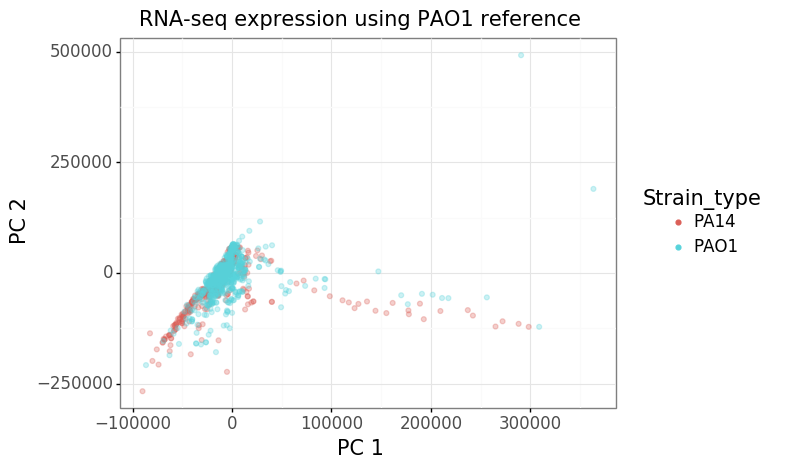

<ggplot: (8783116716141)>


In [33]:
# Plot PAO1
fig = pn.ggplot(pao1_encoded_df, pn.aes(x="1", y="2"))
fig += pn.geom_point(pn.aes(color="Strain_type"), alpha=0.3)
fig += pn.labs(x="PC 1", y="PC 2", title="RNA-seq expression using PAO1 reference")
fig += pn.theme_bw()
fig += pn.theme(
    legend_title_align="center",
    plot_background=pn.element_rect(fill="white"),
    legend_key=pn.element_rect(fill="white", colour="white"),
    legend_title=pn.element_text(family="sans-serif", size=15),
    legend_text=pn.element_text(family="sans-serif", size=12),
    plot_title=pn.element_text(family="sans-serif", size=15),
    axis_text=pn.element_text(family="sans-serif", size=12),
    axis_title=pn.element_text(family="sans-serif", size=15),
)
fig += pn.guides(colour=pn.guide_legend(override_aes={"alpha": 1}))

print(fig)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


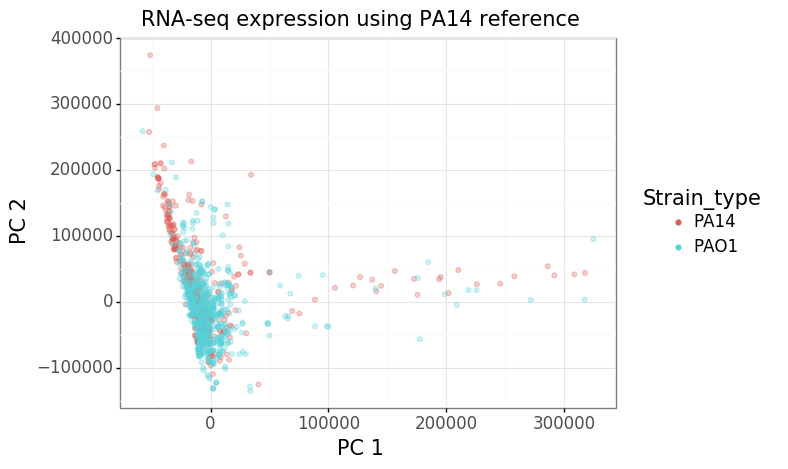

<ggplot: (8783116715181)>


In [34]:
# Plot PA14
fig = pn.ggplot(pa14_encoded_df, pn.aes(x="1", y="2"))
fig += pn.geom_point(pn.aes(color="Strain_type"), alpha=0.3)
fig += pn.labs(x="PC 1", y="PC 2", title="RNA-seq expression using PA14 reference")
fig += pn.theme_bw()
fig += pn.theme(
    legend_title_align="center",
    plot_background=pn.element_rect(fill="white"),
    legend_key=pn.element_rect(fill="white", colour="white"),
    legend_title=pn.element_text(family="sans-serif", size=15),
    legend_text=pn.element_text(family="sans-serif", size=12),
    plot_title=pn.element_text(family="sans-serif", size=15),
    axis_text=pn.element_text(family="sans-serif", size=12),
    axis_title=pn.element_text(family="sans-serif", size=15),
)
fig += pn.guides(colour=pn.guide_legend(override_aes={"alpha": 1}))

print(fig)

#### Try normalizing the data

In [35]:
# 0-1 normalize per gene
scaler = MinMaxScaler()

# Fitting
normalized_pao1_expression_numeric = scaler.fit_transform(pao1_expression_numeric)
normalized_pao1_expression_numeric_df = pd.DataFrame(
    normalized_pao1_expression_numeric,
    columns=pao1_expression_numeric.columns,
    index=pao1_expression_numeric.index,
)

normalized_pa14_expression_numeric = scaler.fit_transform(pa14_expression_numeric)
normalized_pa14_expression_numeric_df = pd.DataFrame(
    normalized_pa14_expression_numeric,
    columns=pa14_expression_numeric.columns,
    index=pa14_expression_numeric.index,
)

In [36]:
# model_pao1 = pca.fit(normalized_pao1_expression_numeric_df)
model_pao1 = umap.UMAP(random_state=123).fit(normalized_pao1_expression_numeric_df)

normalized_pao1_encoded = model_pao1.transform(normalized_pao1_expression_numeric_df)

normalized_pao1_encoded_df = pd.DataFrame(
    data=normalized_pao1_encoded,
    index=normalized_pao1_expression_numeric_df.index,
    columns=["1", "2"],
)

# Add back label
normalized_pao1_encoded_df["Strain_type"] = pao1_expression_label["Strain type"]

# Only include PAO1 and PA14 strains
normalized_pao1_encoded_df = normalized_pao1_encoded_df[
    (normalized_pao1_encoded_df["Strain_type"] == "PAO1")
    | (normalized_pao1_encoded_df["Strain_type"] == "PA14")
]

In [37]:
# model_pa14 = pca.fit(normalized_pa14_expression_numeric_df)
model_pa14 = umap.UMAP(random_state=123).fit(normalized_pa14_expression_numeric_df)

normalized_pa14_encoded = model_pa14.transform(normalized_pa14_expression_numeric_df)

normalized_pa14_encoded_df = pd.DataFrame(
    data=normalized_pa14_encoded,
    index=normalized_pa14_expression_numeric_df.index,
    columns=["1", "2"],
)

# Add back label
normalized_pa14_encoded_df["Strain_type"] = pa14_expression_label["Strain type"]

# Only include PAO1 and PA14 strains
normalized_pa14_encoded_df = normalized_pa14_encoded_df[
    (normalized_pa14_encoded_df["Strain_type"] == "PAO1")
    | (normalized_pa14_encoded_df["Strain_type"] == "PA14")
]

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


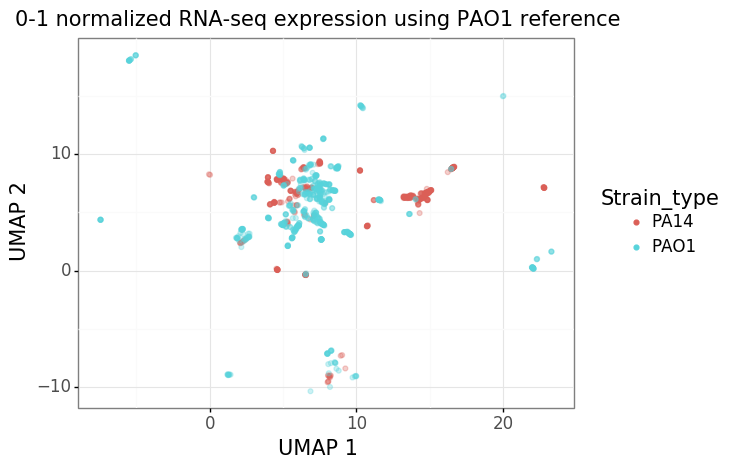

<ggplot: (8783027986737)>


In [38]:
# Plot PAO1
fig = pn.ggplot(normalized_pao1_encoded_df, pn.aes(x="1", y="2"))
fig += pn.geom_point(pn.aes(color="Strain_type"), alpha=0.3)
fig += pn.labs(
    x="UMAP 1",
    y="UMAP 2",
    title="0-1 normalized RNA-seq expression using PAO1 reference",
)
fig += pn.theme_bw()
fig += pn.theme(
    legend_title_align="center",
    plot_background=pn.element_rect(fill="white"),
    legend_key=pn.element_rect(fill="white", colour="white"),
    legend_title=pn.element_text(family="sans-serif", size=15),
    legend_text=pn.element_text(family="sans-serif", size=12),
    plot_title=pn.element_text(family="sans-serif", size=15),
    axis_text=pn.element_text(family="sans-serif", size=12),
    axis_title=pn.element_text(family="sans-serif", size=15),
)
fig += pn.guides(colour=pn.guide_legend(override_aes={"alpha": 1}))

print(fig)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


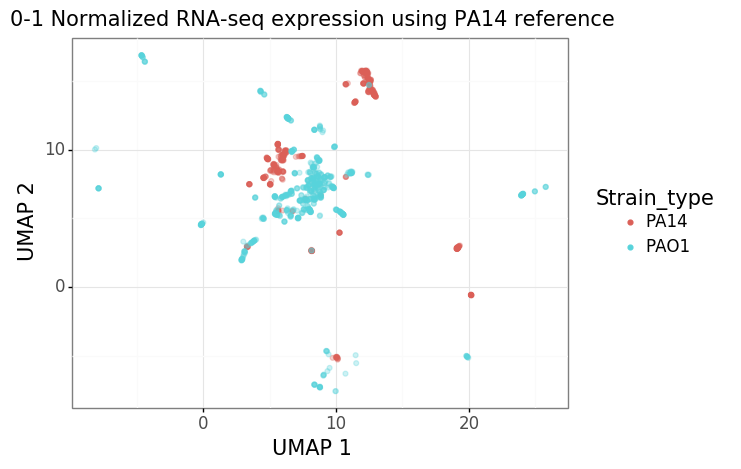

<ggplot: (8783112433825)>


In [39]:
# Plot PA14
fig = pn.ggplot(normalized_pa14_encoded_df, pn.aes(x="1", y="2"))
fig += pn.geom_point(pn.aes(color="Strain_type"), alpha=0.3)
fig += pn.labs(
    x="UMAP 1",
    y="UMAP 2",
    title="0-1 Normalized RNA-seq expression using PA14 reference",
)
fig += pn.theme_bw()
fig += pn.theme(
    legend_title_align="center",
    plot_background=pn.element_rect(fill="white"),
    legend_key=pn.element_rect(fill="white", colour="white"),
    legend_title=pn.element_text(family="sans-serif", size=15),
    legend_text=pn.element_text(family="sans-serif", size=12),
    plot_title=pn.element_text(family="sans-serif", size=15),
    axis_text=pn.element_text(family="sans-serif", size=12),
    axis_title=pn.element_text(family="sans-serif", size=15),
)
fig += pn.guides(colour=pn.guide_legend(override_aes={"alpha": 1}))

print(fig)

#### Plot median core expression

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


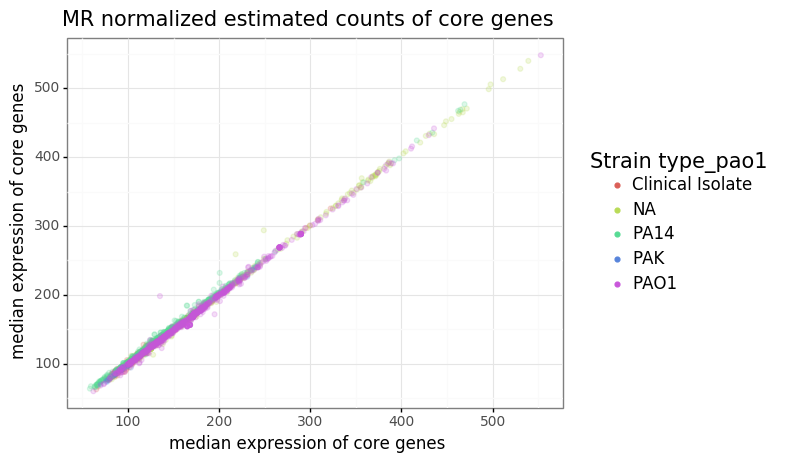

<ggplot: (8783112359741)>


In [40]:
# Plot
fig = pn.ggplot(
    pao1_pa14_core_expression_label,
    pn.aes(x="median core expression_pao1", y="median core expression_pa14"),
)
fig += pn.geom_point(pn.aes(color="Strain type_pao1"), alpha=0.2)
fig += pn.labs(
    x="median expression of core genes",
    y="median expression of core genes",
    title="MR normalized estimated counts of core genes",
)
fig += pn.theme_bw()
fig += pn.theme(
    legend_title_align="center",
    plot_background=pn.element_rect(fill="white"),
    legend_key=pn.element_rect(fill="white", colour="white"),
    legend_title=pn.element_text(family="sans-serif", size=15),
    legend_text=pn.element_text(family="sans-serif", size=12),
    plot_title=pn.element_text(family="sans-serif", size=15),
    axis_text=pn.element_text(family="sans-serif", size=10),
    axis_title=pn.element_text(family="sans-serif", size=12),
)
fig += pn.guides(colour=pn.guide_legend(override_aes={"alpha": 1}))

print(fig)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


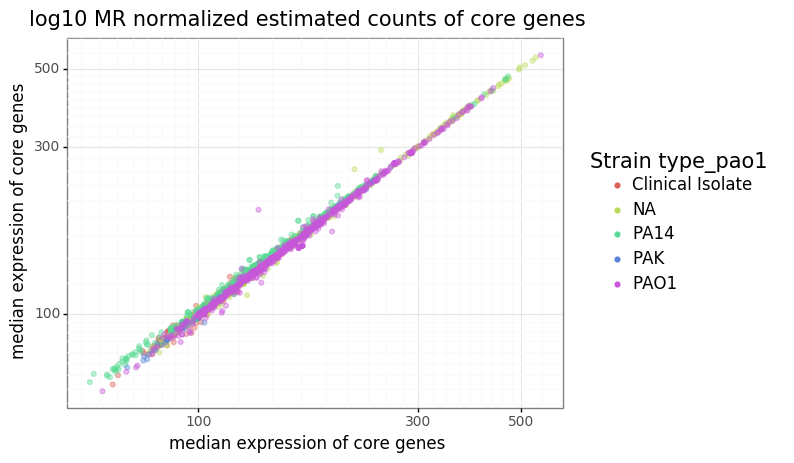

<ggplot: (8783117049349)>


In [41]:
# Plot log-scaled
fig2 = pn.ggplot(
    pao1_pa14_core_expression_label,
    pn.aes(x="median core expression_pao1", y="median core expression_pa14"),
)
fig2 += pn.scales.scale_x_log10()
fig2 += pn.scales.scale_y_log10()
fig2 += pn.geom_point(pn.aes(color="Strain type_pao1"), alpha=0.4)
fig2 += pn.labs(
    x="median expression of core genes",
    y="median expression of core genes",
    title="log10 MR normalized estimated counts of core genes",
)
fig2 += pn.theme_bw()
fig2 += pn.theme(
    legend_title_align="center",
    plot_background=pn.element_rect(fill="white"),
    legend_key=pn.element_rect(fill="white", colour="white"),
    legend_title=pn.element_text(family="sans-serif", size=15),
    legend_text=pn.element_text(family="sans-serif", size=12),
    plot_title=pn.element_text(family="sans-serif", size=15),
    axis_text=pn.element_text(family="sans-serif", size=10),
    axis_title=pn.element_text(family="sans-serif", size=12),
)
fig2 += pn.guides(colour=pn.guide_legend(override_aes={"alpha": 1}))


print(fig2)

**Takeaway:**
* This is a positive control that core genes are expressed in both PAO1 and PA14 samples

* Based on expression profiles of core genes in PAO1 vs PA14 samples, there doesn't look to be a clear clustering amongst PAO1 and PA14 samples. Is this expected?

## Plot: accessory genome

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


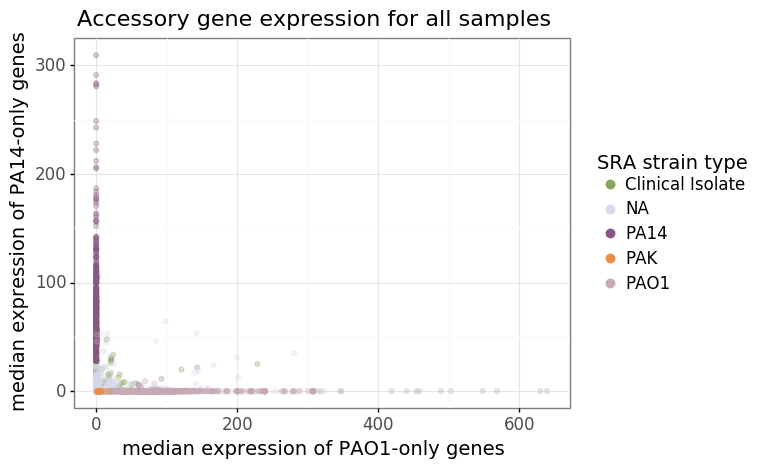

<ggplot: (8783028006081)>


/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: Expression_accessory_genes_all_samples.svg
  warn('Filename: {}'.format(filename))
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [42]:
# Plot
# Note: commented out code is for plotting figure for Georgia's manuscript
colors = {
    "Clinical Isolate": "#89A45E",
    "PA14": "#895881",
    "PAK": "#EF8B46",
    "PAO1": "#C6A9B5",
    "NA": "#D8DAEB",
}

fig3 = pn.ggplot(
    pao1_pa14_acc_expression_label,
    pn.aes(x="median acc expression_pao1", y="median acc expression_pa14"),
)
fig3 += pn.geom_point(
    pn.aes(color="Strain type_pao1"),
    alpha=0.3,
)
fig3 += pn.scale_color_manual(values=colors)
fig3 += pn.labs(
    x="median expression of PAO1-only genes",
    y="median expression of PA14-only genes",
    title="Accessory gene expression for all samples",
    width=10,
)
fig3 += pn.theme_bw()
fig3 += pn.theme(
    legend_title_align="center",
    plot_background=pn.element_rect(fill="white"),
    legend_key=pn.element_rect(fill="white", colour="white"),
    legend_title=pn.element_text(family="sans-serif", size=14),
    legend_text=pn.element_text(family="sans-serif", size=12),
    plot_title=pn.element_text(family="sans-serif", size=16),
    axis_text=pn.element_text(family="sans-serif", size=12),
    axis_title=pn.element_text(family="sans-serif", size=14),
)
fig3 += pn.guides(
    colour=pn.guide_legend(
        title="SRA strain type", override_aes={"alpha": 1, "size": 3}
    )
)

print(fig3)

fig3.save("Expression_accessory_genes_all_samples.svg", format="svg", dpi=300)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


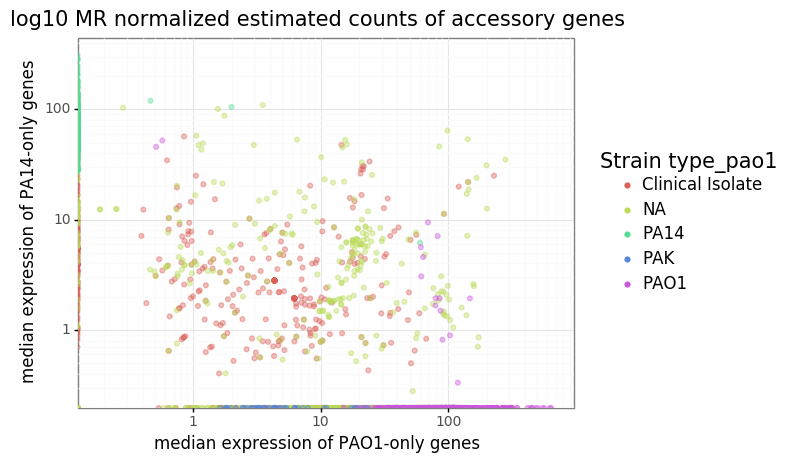

<ggplot: (8783027997385)>


In [43]:
# Plot log-scaled
fig4 = pn.ggplot(
    pao1_pa14_acc_expression_label,
    pn.aes(x="median acc expression_pao1", y="median acc expression_pa14"),
)
fig4 += pn.scales.scale_x_log10()
fig4 += pn.scales.scale_y_log10()
fig4 += pn.geom_point(pn.aes(color="Strain type_pao1"), alpha=0.4)
fig4 += pn.labs(
    x="median expression of PAO1-only genes",
    y="median expression of PA14-only genes",
    title="log10 MR normalized estimated counts of accessory genes",
)
fig4 += pn.theme_bw()
fig4 += pn.theme(
    legend_title_align="center",
    plot_background=pn.element_rect(fill="white"),
    legend_key=pn.element_rect(fill="white", colour="white"),
    legend_title=pn.element_text(family="sans-serif", size=15),
    legend_text=pn.element_text(family="sans-serif", size=12),
    plot_title=pn.element_text(family="sans-serif", size=15),
    axis_text=pn.element_text(family="sans-serif", size=10),
    axis_title=pn.element_text(family="sans-serif", size=12),
)
fig4 += pn.guides(colour=pn.guide_legend(override_aes={"alpha": 1}))


print(fig4)

**Note:**
We can compare TPM between PAO1 and PA14 if they have similar total number of reads mapped. So perhaps we can compare PAO1 and PA14 compendia. See Georgia’s [google doc](https://docs.google.com/document/d/1OnvJNVkhK5ATnhHaeSmz8Ze_Iw9ixXhfSxAL_BSqbuM/edit)

**Takeaway:**
* This is a positive control that PAO1 annotated samples have higher median expression of PAO1-only genes compared to PA14-only genes. And similarly, PA14 annotated samples have higher median expression of PA14-only genes compared to PAO1-only genes. In other words, we expect that PA14-only genes will have either 0 or very low values in PAO1 samples and vice versa.

* This result also shows that we can anticipate a very clear binning of our samples into PAO1 and PA14 if we use mapping rates.

* Note: The NA strains are those where the strain information was not available in the metadata. By a quick manual spot check it looks like a bunch were clinical isolates (which is good since these NA seem to cluster with other clinical isolates).

In [44]:
pao1_sample_ids = pao1_pa14_acc_expression_label["Strain type_pao1"] == "PAO1"
pao1_acc_expression_label = pao1_pa14_acc_expression_label.loc[pao1_sample_ids]
pao1_core_expression_label = pao1_pa14_core_expression_label.loc[pao1_sample_ids]

pa14_sample_ids = pao1_pa14_acc_expression_label["Strain type_pao1"] == "PA14"
pa14_acc_expression_label = pao1_pa14_acc_expression_label.loc[pa14_sample_ids]
pa14_core_expression_label = pao1_pa14_core_expression_label.loc[pa14_sample_ids]

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/alexandra/ana

Text(0.5, 1.0, 'distribution of median(PAO1-only genes)')

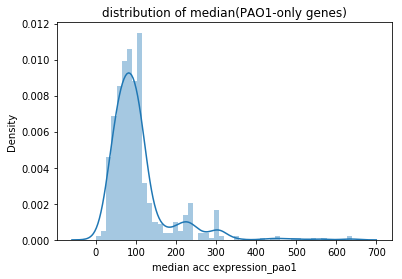

In [45]:
sns.distplot(pao1_acc_expression_label["median acc expression_pao1"])
plt.title("distribution of median(PAO1-only genes)")

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/alexandra/ana

Text(0.5, 1.0, 'distribution of median(core PAO1 genes)')

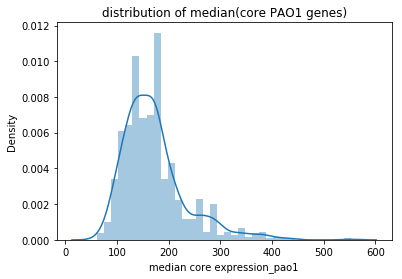

In [46]:
sns.distplot(pao1_core_expression_label["median core expression_pao1"])
plt.title("distribution of median(core PAO1 genes)")

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/alexandra/ana

Text(0.5, 1.0, 'distribution of median(PA14-only genes)')

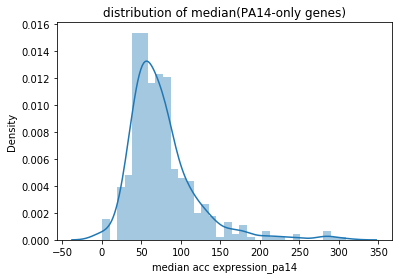

In [47]:
sns.distplot(pa14_acc_expression_label["median acc expression_pa14"])
plt.title("distribution of median(PA14-only genes)")

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/alexandra/ana

Text(0.5, 1.0, 'distribution of median(core PA14 genes)')

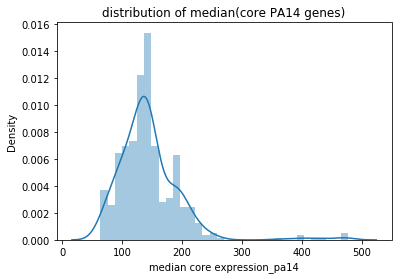

In [48]:
sns.distplot(pa14_core_expression_label["median core expression_pa14"])
plt.title("distribution of median(core PA14 genes)")

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/alexandra/ana

145.4301718588585
6498.5932435014


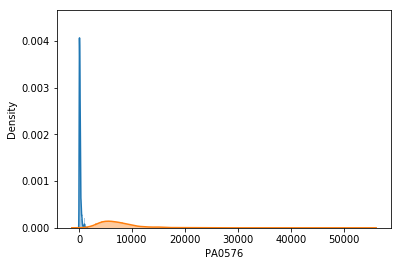

In [49]:
# Examine distribution of expression of individual core genes
# some genes that are considered "housekeeping" genes that you
# might expect to be pretty consistently expressed at decently high levels:
# PA1805 (ppiD), PA0576 (rpoD), PA4368 (rpsL), PA3622 (rpoS), PA3617 (recA)
sns.distplot(pao1_pa14_core_expression_label["PA0485"])
print(pao1_pa14_core_expression_label["PA0485"].median())
sns.distplot(pao1_pa14_core_expression_label["PA0576"])
print(pao1_pa14_core_expression_label["PA0576"].median())

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/alexandra/ana

85.689994689137
0.32707034356915304


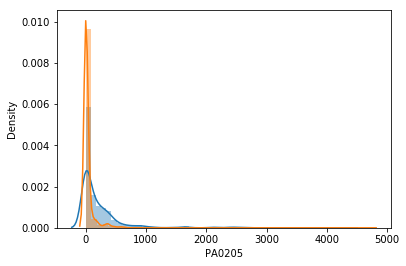

In [50]:
# Examine distribution of expression of individual accessory genes
sns.distplot(pao1_pa14_acc_expression_label["PA1383"])
print(pao1_pa14_acc_expression_label["PA1383"].median())
sns.distplot(pao1_pa14_acc_expression_label["PA0205"])
print(pao1_pa14_acc_expression_label["PA0205"].median())

In [51]:
# Log files
pao1_logs_filename = paths.PAO1_LOGS
pa14_logs_filename = paths.PA14_LOGS

In [52]:
pao1_logs = pd.read_csv(pao1_logs_filename, index_col=0, header=0)
pa14_logs = pd.read_csv(pa14_logs_filename, index_col=0, header=0)

In [53]:
pao1_logs.head()

,lib_types,reads_processed,reads_mapped,mapping_rate,run,job
exp_num,,,,,,
SRP090296/SRX2185323/SRX2185323,[u'SF'],47468450,5240148,11.039223,78041,2724
ERP105395/ERX2259197/ERX2259197,[u'U'],34109390,16420150,48.139676,78036,984
SRP017679/SRX2366135/SRX2366135,[u'U'],9912084,4322668,43.610082,78042,1232
SRP038697/SRX474161/SRX474161,[u'SF'],710589,93493,13.157113,78041,2560
SRP062215/SRX1140456/SRX1140456,[u'SF'],6598795,470748,7.133848,78042,1439


/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/alexandra/ana

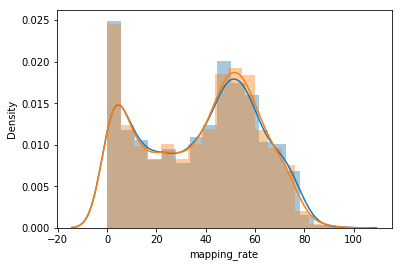

In [54]:
sns.distplot(pao1_logs["mapping_rate"])
sns.distplot(pa14_logs["mapping_rate"])

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/alexandra/ana

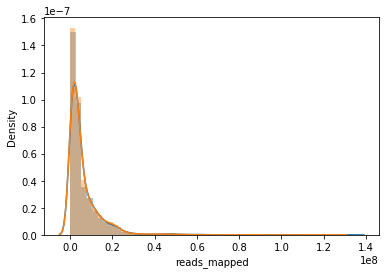

In [55]:
sns.distplot(pao1_logs["reads_mapped"])
sns.distplot(pa14_logs["reads_mapped"])

**Takeaway:**
* As expected, PA14 samples tend to have 0 expression of PAO1-only genes. And similarly for PAO1 samples

### Examine samples on the diagonal
* Curious about the samples that have expression of both PAO1 and PA14 specific genes. Mostly clinical isolates, but some PAO1 and PA14 samples.
* Our binning will likely remove these samples, so we just want to make sure we know who they are before we do

In [56]:
# Get samples with high expression of both PAO1 and PA14 specific genes
pao1_pa14_acc_expression_label[
    (pao1_pa14_acc_expression_label["median acc expression_pao1"] > 50)
    & (pao1_pa14_acc_expression_label["median acc expression_pa14"] > 50)
]

,PA2192,PA0498,PA0135,PA3152,PA3502,PA2976,PA2771,PA4192,PA0457.1,PA0204,...,PA14_59400,PA14_31100,PA14_54050,PA14_15590,PA14_39480,PA14_35850,PA14_51530,PA14_15490,Strain type_pa14,median acc expression_pa14
SRX6437734,0.000000,2.519517,43.671627,0.0,384.646257,3172.911697,0.839839,16.796780,0.000000,0.839839,...,1643.583809,16.987946,101.927678,0.0,0.0,3.397589,2801.312353,0.0,NA,64.129497
SRX6911057,146.234017,0.000000,63.786532,0.0,0.000000,1465.054490,456.345134,400.362274,170.323611,0.000000,...,585.250759,128.002213,0.000000,0.0,0.0,0.000000,0.000000,0.0,NA,53.562423


About selected samples:
* All samples are from [Thoming et. al. publication](https://pubmed.ncbi.nlm.nih.gov/31934344/), where clinical isolates were grown in planktonic and biofilm conditions

Not much I could find about these samples other than they are clinical isolates that seem to have acquired accessory genes from both PAO1 and PA14, which is interesting!

In [57]:
# Get PAO1 samples with high expression of PA14 specific genes
pao1_acc_expression_label[pao1_acc_expression_label["median acc expression_pa14"] > 25]

,PA2192,PA0498,PA0135,PA3152,PA3502,PA2976,PA2771,PA4192,PA0457.1,PA0204,...,PA14_59400,PA14_31100,PA14_54050,PA14_15590,PA14_39480,PA14_35850,PA14_51530,PA14_15490,Strain type_pa14,median acc expression_pa14
SRX5290923,0.0,0.000000,1.022140,1.533211,0.000000,2472.557490,0.51107,0.0,1.022140,0.0,...,443.382939,2.548178,30.578134,1566.619716,603.408505,1085.523746,710.431973,4.077084,PAO1,45.612383
SRX5290924,0.0,0.571359,1.142718,1.142718,0.571359,2533.977074,0.00000,0.0,0.571359,0.0,...,626.505461,1.708651,43.285832,1938.180075,789.966431,1316.231018,1040.568615,6.265055,PAO1,52.113863


In [58]:
# Get PA14 samples with high expression of PAO1 specific genes
pa14_acc_expression_label[pa14_acc_expression_label["median acc expression_pao1"] > 25]

,PA2192,PA0498,PA0135,PA3152,PA3502,PA2976,PA2771,PA4192,PA0457.1,PA0204,...,PA14_59400,PA14_31100,PA14_54050,PA14_15590,PA14_39480,PA14_35850,PA14_51530,PA14_15490,Strain type_pa14,median acc expression_pa14
SRX4326016,12.171054,59.333886,0.000000,117.146390,54.769741,1758.717236,86.718756,18.256580,56.291123,24.342107,...,6.158171,0.0,0.0,67.739878,21.553597,50.804908,477.258230,4.618628,PA14,6.158171
SRX5099522,5.814822,140.386421,0.000000,491.767819,11.629644,6579.055959,58.978911,16.613778,83.899577,130.418155,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,PA14,0.000000
SRX5099523,1.785312,114.259949,0.000000,557.017252,12.497182,6714.557329,85.694962,17.853117,83.909650,110.689326,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,PA14,0.000000
SRX5099524,7.373495,139.277129,0.819277,549.735020,13.108436,6399.374433,52.433743,18.843376,109.783149,107.325317,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,PA14,0.000000
SRX5290921,7.257383,46.769801,1.612752,384.641291,17.740269,2249.788684,93.539601,8.870135,62.897318,3.225503,...,1.633781,0.0,0.0,3.267563,0.000000,3.267563,7.352016,0.000000,PA14,0.000000
SRX7423386,21.844358,83.233047,2.244875,91.349132,28.319958,2655.427753,236.316233,11.915104,47.142369,100.846679,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,PA14,0.000000
SRX7423388,30.777172,103.423798,2.187210,112.016409,28.121274,2738.699659,260.121787,11.560968,38.432408,102.642651,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,PA14,0.000000


### Summary
**About core gene expression**
* Based on expression profiles of core genes in PAO1 vs PA14 samples, there doesn't look to be a clear clustering amongst PAO1 and PA14 samples. Is this expected?

**About accessory gene expression**
* PAO1 annotated samples have higher median expression of PAO1-only genes compared to PA14-only genes. And vice versa

This is a nice positive control. This result also shows that we can anticipate a very clear binning of our samples into PAO1 and PA14 if we use mapping rates.

**About expression levels**
* PAO1 higher median accessory expression than PA14, maybe PAO1 reference had higher mapping rates. They have similar distributions of total reads mapped and mapping rate. Are there other reasons to explain this?

**About samples with along the diagonal**
* All samples are from Thoming et. al. publication, where clinical isolates were grown in planktonic and biofilm conditions. At this point I’m not sure what to say about these clinical isolates, but something that would be interesting to look into in the future.

* PAO1 samples with high expression of PA14 specific genes
    * Sample names look like they might be switched: https://www.ncbi.nlm.nih.gov/sra?linkname=bioproject_sra_all&from_uid=517074
* PA14 samples with high expression of PAO1 specific genes
    * PA14 grown in blood: https://www.ncbi.nlm.nih.gov/sra/?term=SRX4326016
    * Some are mislabeled after checking publication: https://www.ncbi.nlm.nih.gov/sra/?term=SRX5099522, https://www.ncbi.nlm.nih.gov/sra/?term=SRX5099523, https://www.ncbi.nlm.nih.gov/sra/?term=SRX5099524
    * PA14 following treatment with antimicrobial manuka honey: https://www.ncbi.nlm.nih.gov/sra/?term=SRX7423386, https://www.ncbi.nlm.nih.gov/sra/?term=SRX7423388

Based on this quick spot check, it does look like most cases where PAO1 samples with high PA14 gene expression or PA14 samples with high PAO1 expression appear to be due to mis-labelings. This supports our plans to auto-label samples based on mapping rates instead.